# Experiments on signal recognition using a synthesised data set

An exercise based on: 

[1] Timothy J O'Shea, Johnathan Corgan, T. Charles Clancy, "Convolutional Radio Modulation Recognition Networks", Engineering Applications of Neural Networks: 17th International Conference, Feb. 2016.

Note that I am using the dataset RML2016.10a that I have downloaded from:
https://www.deepsig.io/datasets/.
This dataset has a smaller number of examples than the dataset used in [1]. 

The version herein is using a 2D convolutational neural network.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mtl
import seaborn as sns
import _pickle
import math
import keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D,Convolution2D, MaxPooling2D, ZeroPadding2D, Conv1D, ZeroPadding1D
from keras.regularizers import *
from keras.optimizers import adam

Using TensorFlow backend.


In [2]:
#Load the dataset
#Note that the dataset is saved in a pickle date format
#Xd is saved as a dictionarry of numpy.ndarray
Xd = _pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding='latin')

### extract and reorganise data

In [3]:
constellation_list=[]
SNR_list=[]
for e in set(Xd.keys()):
    if e[0] not in constellation_list:
        constellation_list.append(e[0])
    if e[1] not in SNR_list:
        SNR_list.append(e[1])
SNR_list.sort()

tmp=Xd[constellation_list[0], SNR_list[0]].shape

num_classes=len(constellation_list)
num_examples_psact=tmp[0]#number of examples per SNR value and constellation type
num_channels=tmp[1]
num_time_samples=tmp[2]

print("The number of classes (different modulation types) is:")
print(num_classes)
print("...and they are the following ones:")
print(constellation_list)
print("...with the following SNRs:")
print(SNR_list)
print("For each modulation type and SNR value, we have %s examples, each with %s channels (I&Q) and %s time samples" %(num_examples_psact,num_channels,num_time_samples))

    

The number of classes (different modulation types) is:
11
...and they are the following ones:
['QAM64', 'AM-SSB', 'QAM16', '8PSK', 'QPSK', 'BPSK', 'PAM4', 'GFSK', 'WBFM', 'CPFSK', 'AM-DSB']
...with the following SNRs:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
For each modulation type and SNR value, we have 1000 examples, each with 2 channels (I&Q) and 128 time samples


In [4]:
# create training and test set
tr_set_size_psact=math.ceil(0.9*num_examples_psact);
test_set_size_psact=num_examples_psact-tr_set_size_psact;


num_examples=num_examples_psact*num_classes*len(SNR_list)
tr_set_size=math.ceil(0.9*num_examples);
test_set_size=num_examples-tr_set_size;


# I.e. for each SNR and constellation type, the first tr_set_size examples are use for training and the remaining
# are user for test. I assume the different examples are statistically independent.


#reorganise the training data in an np.array for vectorisation 
Xd_training=dict()
X_tr=np.zeros([num_time_samples,num_channels,tr_set_size])
Y_tr=np.zeros([num_classes,tr_set_size]) #using one hot encoding

idx=0
for e in set(Xd.keys()):
    #Xd_training[e]=Xd[e][0:tr_set_size_psact,:,:].reshape(tr_set_size_psact,num_channels*num_time_samples,order='C')
    Xd_training[e]=Xd[e][0:tr_set_size_psact,:,:]
    for j in np.arange(tr_set_size_psact):
        X_tr[:,:,j+idx*tr_set_size_psact]=np.transpose(Xd_training[e][j,:])
        Y_tr[:,j+idx*tr_set_size_psact]=keras.utils.to_categorical(constellation_list.index(e[0]),num_classes)
    idx=idx+1
    

#I randomise X_tr w.r.t to columns, in a way to speed up training 
perm=np.random.permutation(np.arange(tr_set_size))
X_tr=np.transpose(X_tr[:,:,perm])
Y_tr=np.transpose(Y_tr[:,perm])
print("check dimensions")
print("X_tr dimensions:",X_tr.shape)
print("Y_tr dimensions:",Y_tr.shape)   
    


#Build the test data-set

counter=np.zeros(len(SNR_list),dtype=int)
Xd_test=dict.fromkeys(SNR_list)
Yd_test=dict.fromkeys(SNR_list)
#init dictionary
for SINR in SNR_list:
    Xd_test[SINR]=np.zeros([test_set_size_psact*len(constellation_list),num_channels,num_time_samples])
    Yd_test[SINR]=np.zeros([test_set_size_psact*len(constellation_list),num_classes])


for e in set(Xd.keys()):
    j=counter[SNR_list.index(e[1])]
    Xd_test[e[1]][j*test_set_size_psact:(j+1)*test_set_size_psact,:,:]=Xd[e][tr_set_size_psact : num_examples_psact,:,:]
    Yd_test[e[1]][j*test_set_size_psact:(j+1)*test_set_size_psact,:]=keras.utils.to_categorical(constellation_list.index(e[0]),num_classes)
    counter[SNR_list.index(e[1])]=counter[SNR_list.index(e[1])]+1; 

check dimensions
X_tr dimensions: (198000, 2, 128)
Y_tr dimensions: (198000, 11)


### Implement the NN

In [ ]:
#build the model
dr=0.35
keras.backend.clear_session()
model=keras.models.Sequential()

if X_tr.ndim < 4: 
    X_tr = np.expand_dims(X_tr, axis=3)


model.add(Convolution2D(64,1,7,activation="relu",name="conv1",input_shape=X_tr.shape[1:]))
#model.add(Dropout(dr))
model.add(MaxPooling2D(pool_size=(1,4)))
model.add(Convolution2D(128, 2, 7, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(num_classes, init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
#model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()


#train the network
#history=model.fit(X_tr,Y_tr,epochs=80, batch_size=256,validation_split=0.2,callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto')])
history=model.fit(X_tr,Y_tr,epochs=100, batch_size=256,validation_split=0.2)

### plot the loss and accuracy for training and validation sets

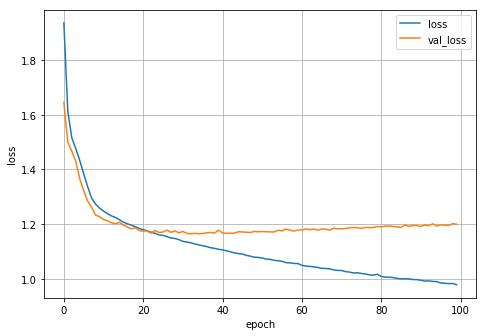

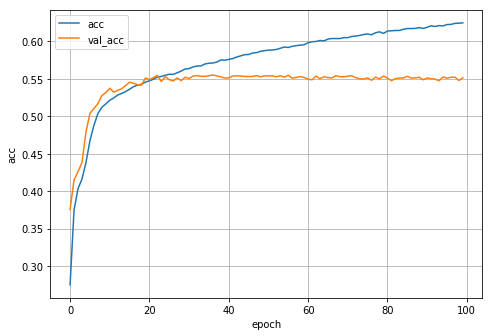

In [6]:
loss=np.array(history.history['loss'])
acc=history.history['acc']
val_loss=history.history['val_loss']
val_acc=history.history['val_acc']


fig1=mtl.pyplot.figure()
fig2=mtl.pyplot.figure()


axes1=fig1.add_axes([0,0,1,1])
axes2=fig2.add_axes([0,0,1,1])
axes1.plot(loss,label='loss')
axes2.plot(acc,label='acc')
axes1.plot(val_loss,label='val_loss')
axes2.plot(val_acc,label='val_acc')
axes1.set_xlabel('epoch')
axes1.set_ylabel('loss')
axes1.legend()
axes1.grid(b=True,axis='both')
axes2.set_xlabel('epoch')
axes2.set_ylabel('acc')
axes2.legend()
axes2.grid(b=True,axis='both')

### plot accuracy for the test set as a function of the SNR

In [ ]:
#test the model on the training set
loss_vec=np.zeros([len(SNR_list),1])
acc_vec=np.zeros([len(SNR_list),1])
index=0

for SNR in SNR_list:
    tmp1=np.copy(Xd_test[SNR])
    tmp2=np.copy(Yd_test[SNR])
    tmp1=np.expand_dims(tmp1, axis=3)
    tmp2=np.expand_dims(tmp2, axis=3)
    print(tmp1.shape)
    
    loss_vec[index],acc_vec[index]=model.evaluate(tmp1,Yd_test[SNR])
    index=index+1

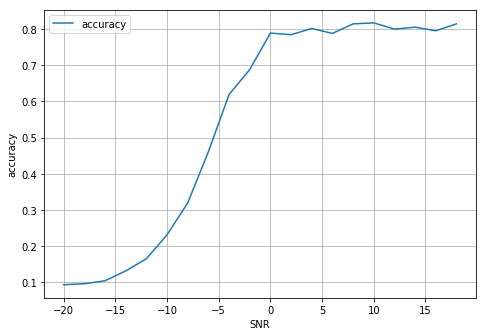

In [8]:
fig1=mtl.pyplot.figure()
axes2=fig1.add_axes([0,0,1,1])
#axes1.plot(SNR_list,loss_vec,label='loss')
axes2.plot(SNR_list,acc_vec,label='accuracy')
axes2.set_xlabel('SNR')
axes2.set_ylabel('accuracy')
axes2.legend()
axes2.grid(b=True,axis='both')